In [9]:
# Import packages
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.utils import resample

# Load the dataset
df = pd.read_csv('data.csv')

# Data exploration
df.describe()

# Data Preprocessing: Drop irrelevant columns
df_cleaned = df.drop(columns=['id', 'Unnamed: 32'])

# Convert 'diagnosis' column to binary format
label_encoder = LabelEncoder()
df_cleaned['diagnosis'] = label_encoder.fit_transform(df_cleaned['diagnosis'])

# Split the dataset into features (X) and target (y)
X = df_cleaned.drop(columns=['diagnosis'])
y = df_cleaned['diagnosis']

# Get the size of the original dataset
original_size = df_cleaned.shape[0]
print(f"Original Dataset Size: {original_size}")

print(f"Number of people affected by cancer before SMOTE: {sum(y == 1)}")
print(f"Number of people not affected by cancer before SMOTE: {sum(y == 0)}")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to balance the training set (oversampling the minority class)
smote = SMOTE(sampling_strategy='auto', random_state=42)  # Updated without n_jobs
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check if additional samples are needed to reach 13,000 rows (Optional)
desired_samples = 13000
current_size = X_train_resampled.shape[0]

if current_size < desired_samples:
    additional_samples = desired_samples - current_size
    # Concatenate X_train_resampled and y_train_resampled into a single dataframe
    resampled_data = pd.concat([pd.DataFrame(X_train_resampled), pd.DataFrame(y_train_resampled, columns=['diagnosis'])], axis=1)
    
    # Perform upsampling to reach desired number of rows
    resampled_upsampled = resample(resampled_data, replace=True, n_samples=additional_samples, random_state=42)
    
    # Append the upsampled data to the original resampled data
    final_resampled_data = pd.concat([resampled_data, resampled_upsampled])
    
    # Separate features and target from the final dataset
    X_train_resampled = final_resampled_data.drop(columns=['diagnosis'])
    y_train_resampled = final_resampled_data['diagnosis']


# Get the size of the resampled (augmented) dataset
resampled_size = X_train_resampled.shape[0]
print(f"Dataset Size After Augmentation: {resampled_size}")

print(f"Number of people affected by cancer after SMOTE: {sum(y_train_resampled == 1)}")
print(f"Number of people not affected by cancer after SMOTE: {sum(y_train_resampled == 0)}")

# Initialize the Logistic Regression and Linear Regression models
log_reg = LogisticRegression(max_iter=10000)
lin_reg = LinearRegression()

# 1. Recursive Feature Elimination (RFE)
rfe = RFE(log_reg, n_features_to_select=10)
rfe.fit(X_train_resampled, y_train_resampled)
X_train_rfe = rfe.transform(X_train_resampled)
X_test_rfe = rfe.transform(X_test)

# 2. Principal Component Analysis (PCA)
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train_resampled)
X_test_pca = pca.transform(X_test)

# 3. Gradient Boosting Classifier for Feature Importance
gb = GradientBoostingClassifier()
gb.fit(X_train_resampled, y_train_resampled)
feature_importances = gb.feature_importances_
indices = feature_importances.argsort()[-10:]  # Select top 10 features
X_train_gb = X_train_resampled.iloc[:, indices]
X_test_gb = X_test.iloc[:, indices]

# Prepare a dictionary to hold the results
results = {}

# Logistic Regression on RFE-selected features
log_reg.fit(X_train_rfe, y_train_resampled)
y_pred_rfe_log = log_reg.predict(X_test_rfe)
results['RFE_Logistic_Regression'] = accuracy_score(y_test, y_pred_rfe_log)

# Logistic Regression on PCA-transformed features
log_reg.fit(X_train_pca, y_train_resampled)
y_pred_pca_log = log_reg.predict(X_test_pca)
results['PCA_Logistic_Regression'] = accuracy_score(y_test, y_pred_pca_log)

# Logistic Regression on Gradient Boosting selected features
log_reg.fit(X_train_gb, y_train_resampled)
y_pred_gb_log = log_reg.predict(X_test_gb)
results['GradientBoosting_Logistic_Regression'] = accuracy_score(y_test, y_pred_gb_log)

# Linear Regression on RFE-selected features
lin_reg.fit(X_train_rfe, y_train_resampled)
y_pred_rfe_lin = lin_reg.predict(X_test_rfe)
results['RFE_Linear_Regression'] = accuracy_score(y_test, y_pred_rfe_lin.round())

# Linear Regression on PCA-transformed features
lin_reg.fit(X_train_pca, y_train_resampled)
y_pred_pca_lin = lin_reg.predict(X_test_pca)
results['PCA_Linear_Regression'] = accuracy_score(y_test, y_pred_pca_lin.round())

# Linear Regression on Gradient Boosting selected features
lin_reg.fit(X_train_gb, y_train_resampled)
y_pred_gb_lin = lin_reg.predict(X_test_gb)
results['GradientBoosting_Linear_Regression'] = accuracy_score(y_test, y_pred_gb_lin.round())

# Display the results
for method, accuracy in results.items():
    print(f"{method}: {accuracy*100:.2f}%")


Original Dataset Size: 569
Number of people affected by cancer before SMOTE: 212
Number of people not affected by cancer before SMOTE: 357
Dataset Size After Augmentation: 13000
Number of people affected by cancer after SMOTE: 6518
Number of people not affected by cancer after SMOTE: 6482
RFE_Logistic_Regression: 95.61%
PCA_Logistic_Regression: 96.49%
GradientBoosting_Logistic_Regression: 97.37%
RFE_Linear_Regression: 92.98%
PCA_Linear_Regression: 93.86%
GradientBoosting_Linear_Regression: 93.86%


In [11]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# 1. Filter the cancer-positive patients (diagnosis == 1)
cancer_positive = final_resampled_data[final_resampled_data['diagnosis'] == 1]

# Remove the 'diagnosis' column for clustering purposes
X_cancer_positive = cancer_positive.drop(columns=['diagnosis'])

# 2. Apply K-Means Clustering to divide patients into 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X_cancer_positive)

# 3. Get cluster labels and assign them as stages
cancer_positive['stage'] = kmeans.labels_

# Map cluster labels to stages 1, 2, 3, 4
cancer_positive['stage'] = cancer_positive['stage'].map({
    0: 'Stage 1',
    1: 'Stage 2',
    2: 'Stage 3',
    3: 'Stage 4'
})

# Display the number of patients in each stage
print(cancer_positive['stage'].value_counts())

# 4. Evaluate the clustering performance
# Using Silhouette Score as a metric for the quality of clustering
sil_score = silhouette_score(X_cancer_positive, kmeans.labels_)
print(f"Silhouette Score for K-Means Clustering: {sil_score:.4f}")

# Optional: Get the inertia (sum of squared distances to nearest cluster center)
inertia = kmeans.inertia_
print(f"Inertia of the K-Means Clustering: {inertia:.4f}")


C:\Users\hardi\AppData\Local\Temp\ipykernel_18020\2489716824.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cancer_positive['stage'] = kmeans.labels_
C:\Users\hardi\AppData\Local\Temp\ipykernel_18020\2489716824.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cancer_positive['stage'] = cancer_positive['stage'].map({


stage
Stage 1    2463
Stage 4    2065
Stage 2    1676
Stage 3     314
Name: count, dtype: int64
Silhouette Score for K-Means Clustering: 0.4986
Inertia of the K-Means Clustering: 424837189.0454


C:\Users\hardi\AppData\Local\Temp\ipykernel_18020\1199515984.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['Stage 4' 'Stage 4' 'Stage 4' 'Stage 1' 'Stage 4' 'Stage 1' 'Stage 2'
 'Stage 1' 'Stage 1' 'Stage 1' 'Stage 2' 'Stage 2' 'Stage 2' 'Stage 1'
 'Stage 1' 'Stage 1' 'Stage 1' 'Stage 2' 'Stage 4' 'Stage 1' 'Stage 3'
 'Stage 4' 'Stage 2' 'Stage 1' 'Stage 2' 'Stage 2' 'Stage 2' 'Stage 2'
 'Stage 1' 'Stage 2' 'Stage 4' 'Stage 2' 'Stage 2' 'Stage 1' 'Stage 1'
 'Stage 1' 'Stage 1' 'Stage 1' 'Stage 2' 'Stage 1' 'Stage 1' 'Stage 2'
 'Stage 1' 'Stage 2' 'Stage 1' 'Stage 4' 'Stage 1' 'Stage 1' 'Stage 1'
 'Stage 1' 'Stage 4' 'Stage 2' 'Stage 1' 'Stage 2' 'Stage 2' 'Stage 4'
 'Stage 3' 'Stage 2' 'Stage 2' 'Stage 1' 'Stage 2' 'Stage 1' 'Stage 1'
 'Stage 4' 'Stage 1' 'Stage 1' 'Stage 1' 'Stage 4' 'Stage 1' 'Stage 2'
 'Stage 2' 'Stage 2' 'Stage 4' 'Stage 1' 'Stage 2' 'Stage 2' 'Stage 1'
 'Stage 2' 'Stage 2' 'Stage 1' 'S

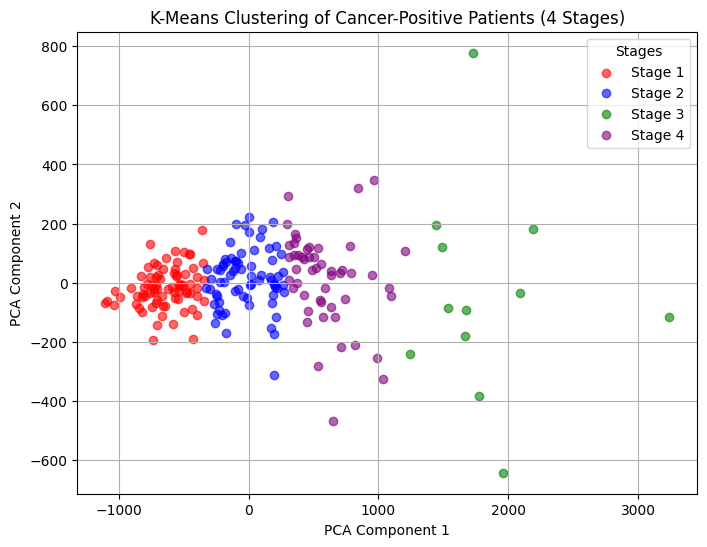

Inertia: 14178612.069333524


In [12]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming you already have your data loaded and cleaned
# Filter out the cancer-positive patients
cancer_positive = df_cleaned[df_cleaned['diagnosis'] == 1].copy()

# Apply PCA to reduce the dimensionality to 2 components for visualization purposes
pca = PCA(n_components=2)
X_cancer_pca = pca.fit_transform(cancer_positive.drop(columns=['diagnosis']))

# Apply KMeans clustering to categorize cancer-positive patients into 4 stages
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)  # Fix for the FutureWarning

# Fit the KMeans model to the PCA-transformed data
kmeans.fit(X_cancer_pca)

# Assign cluster labels as stages
cancer_positive.loc[:, 'stage'] = kmeans.labels_

# Map cluster labels to stages 1, 2, 3, and 4
cancer_positive.loc[:, 'stage'] = cancer_positive['stage'].map({
    0: 'Stage 1',
    1: 'Stage 2',
    2: 'Stage 3',
    3: 'Stage 4'
})

# Visualize the clusters using a scatter plot
plt.figure(figsize=(8, 6))

# Assign colors to clusters
colors = ['red', 'blue', 'green', 'purple']
for i, stage in enumerate(['Stage 1', 'Stage 2', 'Stage 3', 'Stage 4']):
    plt.scatter(X_cancer_pca[cancer_positive['stage'] == stage, 0], 
                X_cancer_pca[cancer_positive['stage'] == stage, 1], 
                color=colors[i], label=stage, alpha=0.6)

# Plot customization
plt.title("K-Means Clustering of Cancer-Positive Patients (4 Stages)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Stages")
plt.grid(True)
plt.show()

# Calculate and display the inertia (which can be an indicator of model performance)
print(f"Inertia: {kmeans.inertia_}")


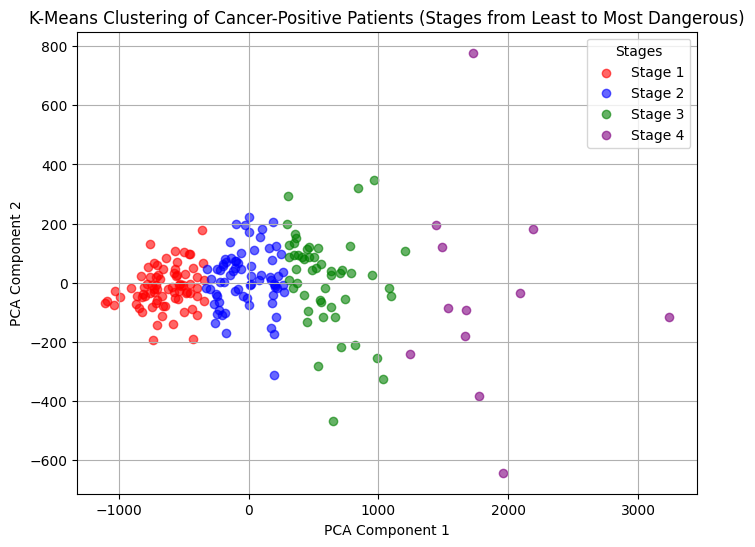

Inertia: 14178612.069333524


In [13]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming you already have your data loaded and cleaned
# Filter out the cancer-positive patients
cancer_positive = df_cleaned[df_cleaned['diagnosis'] == 1].copy()

# Apply PCA to reduce the dimensionality to 2 components for visualization purposes
pca = PCA(n_components=2)
X_cancer_pca = pca.fit_transform(cancer_positive.drop(columns=['diagnosis']))

# Apply KMeans clustering to categorize cancer-positive patients into 4 stages
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)  # Fix for the FutureWarning

# Fit the KMeans model to the PCA-transformed data
kmeans.fit(X_cancer_pca)

# Get the cluster centers and sort them
centroids = kmeans.cluster_centers_
sorted_indices = centroids[:, 0].argsort()  # Sort based on the first PCA component

# Create a mapping from original cluster labels to sorted stage labels
label_mapping = {original_label: sorted_label for sorted_label, original_label in enumerate(sorted_indices)}

# Use numpy indexing to assign the stage labels
cancer_positive['stage'] = np.vectorize(label_mapping.get)(kmeans.labels_)

# Map sorted cluster labels to stages
cancer_positive['stage'] = cancer_positive['stage'].map({
    0: 'Stage 1',  # Least dangerous
    1: 'Stage 2',
    2: 'Stage 3',
    3: 'Stage 4'   # Most dangerous
})

# Visualize the clusters using a scatter plot
plt.figure(figsize=(8, 6))

# Assign colors to clusters
colors = ['red', 'blue', 'green', 'purple']
for i, stage in enumerate(['Stage 1', 'Stage 2', 'Stage 3', 'Stage 4']):
    plt.scatter(X_cancer_pca[cancer_positive['stage'] == stage, 0], 
                X_cancer_pca[cancer_positive['stage'] == stage, 1], 
                color=colors[i], label=stage, alpha=0.6)

# Plot customization
plt.title("K-Means Clustering of Cancer-Positive Patients (Stages from Least to Most Dangerous)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Stages")
plt.grid(True)
plt.show()

# Calculate and display the inertia (which can be an indicator of model performance)
print(f"Inertia: {kmeans.inertia_}")


In [14]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Load your dataset (assuming 'final_resampled_data' is your DataFrame)
# final_resampled_data = pd.read_csv('path_to_your_data.csv')

# 1. Prepare the data (include both positive and negative samples for feature selection)
X_full = final_resampled_data.drop(columns=['diagnosis'])
y_full = final_resampled_data['diagnosis']

# 2. Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_full)

# 3. Feature Selection using RFE with Logistic Regression
log_reg = LogisticRegression(max_iter=10000)  # Increase max_iter for convergence
rfe = RFE(estimator=log_reg, n_features_to_select=10)  # Select top 10 features
rfe.fit(X_scaled, y_full)  # Fit RFE

# Transform the data to keep only selected features
X_selected = rfe.transform(X_scaled)

# 4. Filter the cancer-positive patients (diagnosis == 1)
cancer_positive = final_resampled_data[final_resampled_data['diagnosis'] == 1]

# 5. Standardize the selected features for cancer-positive patients
X_cancer_positive_selected = X_selected[final_resampled_data['diagnosis'] == 1]

# 6. Apply K-Means Clustering to divide patients into 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X_cancer_positive_selected)

# 7. Get cluster labels and assign them as stages
cancer_positive['stage'] = kmeans.labels_

# Map cluster labels to stages 1, 2, 3, 4
cancer_positive['stage'] = cancer_positive['stage'].map({
    0: 'Stage 1',
    1: 'Stage 2',
    2: 'Stage 3',
    3: 'Stage 4'
})

# Display the number of patients in each stage
print(cancer_positive['stage'].value_counts())

# 8. Evaluate the clustering performance
# Using Silhouette Score as a metric for the quality of clustering
sil_score = silhouette_score(X_cancer_positive_selected, kmeans.labels_)
print(f"Silhouette Score for K-Means Clustering: {sil_score:.4f}")

# Optional: Get the inertia (sum of squared distances to nearest cluster center)
inertia = kmeans.inertia_
print(f"Inertia of the K-Means Clustering: {inertia:.4f}")


C:\Users\hardi\AppData\Local\Temp\ipykernel_18020\602977676.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cancer_positive['stage'] = kmeans.labels_
C:\Users\hardi\AppData\Local\Temp\ipykernel_18020\602977676.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cancer_positive['stage'] = cancer_positive['stage'].map({


stage
Stage 2    2554
Stage 1    2033
Stage 3    1513
Stage 4     418
Name: count, dtype: int64
Silhouette Score for K-Means Clustering: 0.2000
Inertia of the K-Means Clustering: 31490.0313


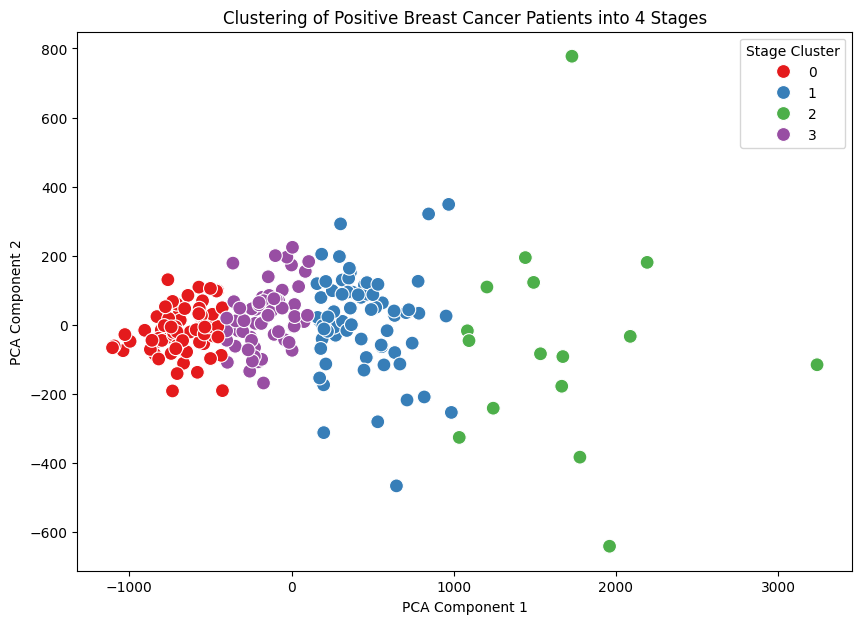

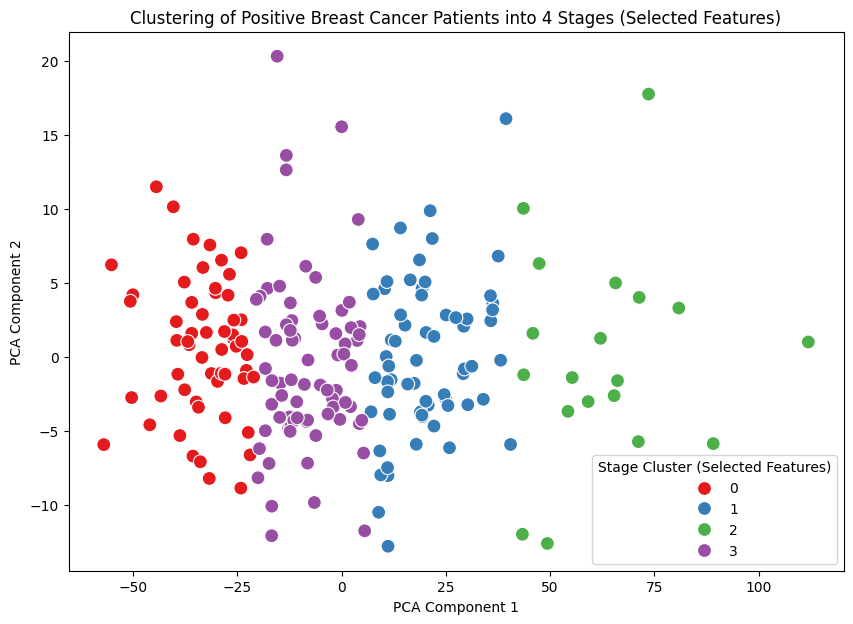

In [15]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Use df_cleaned without the 'diagnosis' column for clustering
X = df_cleaned.drop(columns=['diagnosis'])

# Clustering the patients into two groups: Positive and Negative breast cancer
kmeans_binary = KMeans(n_clusters=2, random_state=42)
df_cleaned['binary_cluster'] = kmeans_binary.fit_predict(X)

# Separate positive breast cancer patients for further clustering
positive_patients = df_cleaned[df_cleaned['diagnosis'] == 1].drop(columns=['binary_cluster'])

# Apply PCA to reduce features to 2 dimensions for visualization
pca_positive = PCA(n_components=2)
positive_patients_pca = pca_positive.fit_transform(positive_patients.drop(columns=['diagnosis']))

# Clustering positive breast cancer patients into 4 clusters (stages)
kmeans_stage = KMeans(n_clusters=4, random_state=42)
positive_patients['stage_cluster'] = kmeans_stage.fit_predict(positive_patients.drop(columns=['diagnosis']))

# Visualize clusters using PCA (2D plot)
plt.figure(figsize=(10, 7))
sns.scatterplot(x=positive_patients_pca[:, 0], y=positive_patients_pca[:, 1], 
                hue=positive_patients['stage_cluster'], palette='Set1', s=100)
plt.title("Clustering of Positive Breast Cancer Patients into 4 Stages")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title='Stage Cluster')
plt.show()

# Evaluate clusters using feature importance from Gradient Boosting (optional)
gb = GradientBoostingClassifier()
gb.fit(X_train_resampled, y_train_resampled)
important_features = gb.feature_importances_

# Select top N important features (e.g., top 10) and re-cluster
top_n_features_indices = np.argsort(important_features)[-10:]
X_selected = X.iloc[:, top_n_features_indices]

# Re-run clustering on selected features
kmeans_binary_selected = KMeans(n_clusters=2, random_state=42)
df_cleaned['cluster_selected'] = kmeans_binary_selected.fit_predict(X_selected)

# Re-run clustering for positive patients with selected features
positive_patients_selected = positive_patients.iloc[:, top_n_features_indices]
kmeans_stage_selected = KMeans(n_clusters=4, random_state=42)
positive_patients['stage_cluster_selected'] = kmeans_stage_selected.fit_predict(positive_patients_selected)

# Plotting the new clusters based on selected features
plt.figure(figsize=(10, 7))
positive_patients_pca_selected = PCA(n_components=2).fit_transform(positive_patients_selected)
sns.scatterplot(x=positive_patients_pca_selected[:, 0], y=positive_patients_pca_selected[:, 1], 
                hue=positive_patients['stage_cluster_selected'], palette='Set1', s=100)
plt.title("Clustering of Positive Breast Cancer Patients into 4 Stages (Selected Features)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title='Stage Cluster (Selected Features)')
plt.show()


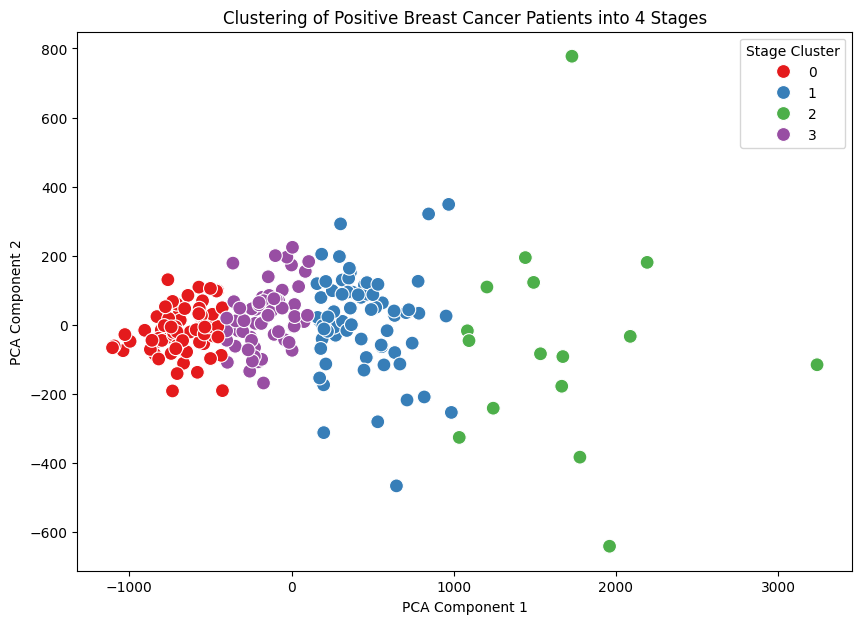

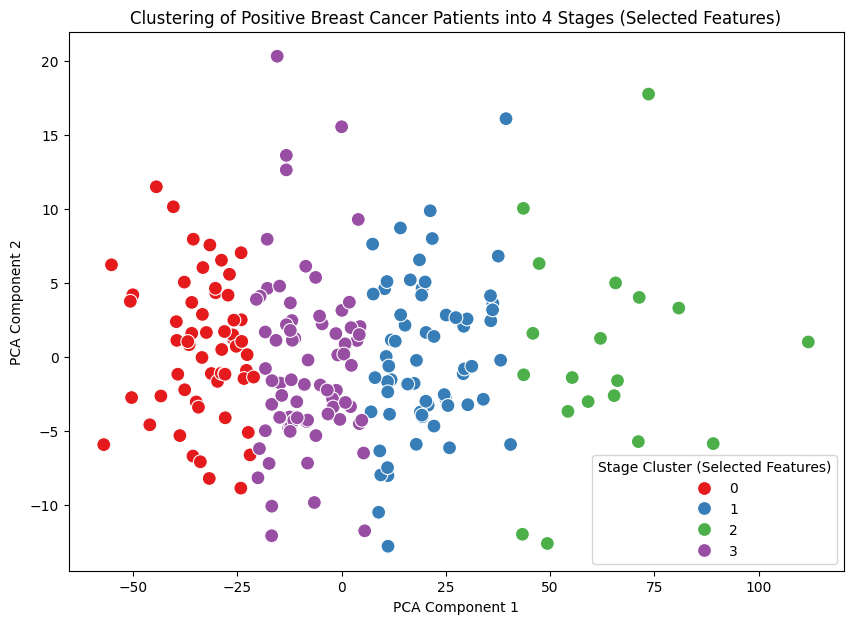

In [17]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier

# Load the dataset
df = pd.read_csv('data.csv')

# Data Preprocessing: Drop irrelevant columns
df_cleaned = df.drop(columns=['id', 'Unnamed: 32'])

# Convert 'diagnosis' column to binary format (1 for malignant, 0 for benign)
label_encoder = LabelEncoder()
df_cleaned['diagnosis'] = label_encoder.fit_transform(df_cleaned['diagnosis'])

# Use df_cleaned without the 'diagnosis' column for clustering
X = df_cleaned.drop(columns=['diagnosis'])

# Clustering the patients into two groups: Positive and Negative breast cancer
kmeans_binary = KMeans(n_clusters=2, random_state=42)
df_cleaned['binary_cluster'] = kmeans_binary.fit_predict(X)

# Separate positive breast cancer patients for further clustering
positive_patients = df_cleaned[df_cleaned['diagnosis'] == 1].drop(columns=['binary_cluster'])

# Apply PCA to reduce features to 2 dimensions for visualization
pca_positive = PCA(n_components=2)
positive_patients_pca = pca_positive.fit_transform(positive_patients.drop(columns=['diagnosis']))

# Clustering positive breast cancer patients into 4 clusters (stages)
kmeans_stage = KMeans(n_clusters=4, random_state=42)
positive_patients['stage_cluster'] = kmeans_stage.fit_predict(positive_patients.drop(columns=['diagnosis']))

# Visualize clusters using PCA (2D plot)
plt.figure(figsize=(10, 7))
sns.scatterplot(x=positive_patients_pca[:, 0], y=positive_patients_pca[:, 1], 
                hue=positive_patients['stage_cluster'], palette='Set1', s=100)
plt.title("Clustering of Positive Breast Cancer Patients into 4 Stages")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title='Stage Cluster')
plt.show()

# Evaluate clusters using feature importance from Gradient Boosting (optional)
# Split data into training and testing sets (assuming X_train_resampled, y_train_resampled are available)
gb = GradientBoostingClassifier()
gb.fit(X, df_cleaned['diagnosis'])
important_features = gb.feature_importances_

# Select top N important features (e.g., top 10) and re-cluster
top_n_features_indices = np.argsort(important_features)[-10:]
X_selected = X.iloc[:, top_n_features_indices]

# Re-run clustering on selected features
kmeans_binary_selected = KMeans(n_clusters=2, random_state=42)
df_cleaned['cluster_selected'] = kmeans_binary_selected.fit_predict(X_selected)

# Re-run clustering for positive patients with selected features
positive_patients_selected = positive_patients.iloc[:, top_n_features_indices]
kmeans_stage_selected = KMeans(n_clusters=4, random_state=42)
positive_patients['stage_cluster_selected'] = kmeans_stage_selected.fit_predict(positive_patients_selected)

# Plotting the new clusters based on selected features
plt.figure(figsize=(10, 7))
positive_patients_pca_selected = PCA(n_components=2).fit_transform(positive_patients_selected)
sns.scatterplot(x=positive_patients_pca_selected[:, 0], y=positive_patients_pca_selected[:, 1], 
                hue=positive_patients['stage_cluster_selected'], palette='Set1', s=100)
plt.title("Clustering of Positive Breast Cancer Patients into 4 Stages (Selected Features)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title='Stage Cluster (Selected Features)')
plt.show()
